# Facial Expression Detection Using the Viola–Jones Algorithm

## Abstract
This notebook implements a three-stage emotion recognition system:
1. **Face Detection** - Using Viola–Jones algorithm
2. **Feature Extraction** - Raw pixels (System 1) and HOG features (System 2)
3. **Classification** - Support Vector Machines (SVM) with different kernels

The system is evaluated on the **FER13 dataset** with 7 emotions:
- Angry, Disgust, Fear, Happy, Neutral, Sad, Surprise

## 1. Import Required Libraries
Import necessary libraries for face detection, feature extraction, and classification.

'numpy' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [3]:
# Import required libraries
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore the FER13 Dataset

Load the FER13 dataset containing seven emotion classes: **Angry, Disgust, Fear, Happy, Neutral, Sad, Surprise**.

The dataset structure is:
```
FER13/
├── train/
│   ├── angry/
│   ├── disgust/
│   ├── fear/
│   ├── happy/
│   ├── neutral/
│   ├── sad/
│   └── surprise/
├── test/
│   └── ...
└── validation/
    └── ...
```

In [2]:
# ============================================================
# FER13 DATASET CONFIGURATION
# ============================================================
DATASET_PATH = r"C:\Users\Zayani\Desktop\projet machine learning\FER13"

# Define the seven emotion classes (matching your folder names)
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load images and labels from a specific split (train, test, or validation)
def load_dataset_split(dataset_path, split, emotions):
    """
    Load all images from a specific dataset split.
    
    Parameters:
    -----------
    dataset_path : str
        Root path to the FER13 dataset
    split : str
        Dataset split: 'train', 'test', or 'val'
    emotions : list
        List of emotion class names
        
    Returns:
    --------
    images : list
        List of loaded images
    labels : list
        Corresponding emotion labels
    """
    images = []
    labels = []
    
    split_path = os.path.join(dataset_path, split)
    
    if not os.path.exists(split_path):
        print(f"Warning: {split_path} does not exist!")
        return images, labels
    
    for emotion in emotions:
        emotion_path = os.path.join(split_path, emotion)
        if not os.path.exists(emotion_path):
            print(f"Warning: {emotion_path} does not exist!")
            continue
            
        # Get all image files (common formats)
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif']:
            image_files.extend(glob(os.path.join(emotion_path, ext)))
            image_files.extend(glob(os.path.join(emotion_path, ext.upper())))
        
        print(f"  Loading {len(image_files)} images from {split}/{emotion}...")
        
        for img_path in image_files:
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(emotion)
    
    return images, labels

# Load all splits
print("Loading FER13 Dataset...")
print("="*60)

print("\n📁 Loading TRAINING set:")
train_images, train_labels = load_dataset_split(DATASET_PATH, 'train', EMOTIONS)

print("\n📁 Loading VALIDATION set:")
val_images, val_labels = load_dataset_split(DATASET_PATH, 'val', EMOTIONS)  # Changed to 'val'

print("\n📁 Loading TEST set:")
test_images, test_labels = load_dataset_split(DATASET_PATH, 'test', EMOTIONS)

print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Training images:   {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images:       {len(test_images)}")
print(f"Total images:      {len(train_images) + len(val_images) + len(test_images)}")

Loading FER13 Dataset...

📁 Loading TRAINING set:
  Loading 12944 images from train/angry...
  Loading 12944 images from train/disgust...
  Loading 12944 images from train/fear...
  Loading 12944 images from train/happy...
  Loading 12944 images from train/neutral...
  Loading 12944 images from train/sad...
  Loading 12944 images from train/surprise...

📁 Loading VALIDATION set:
  Loading 3236 images from val/angry...
  Loading 3236 images from val/disgust...
  Loading 3236 images from val/fear...
  Loading 3236 images from val/happy...
  Loading 3236 images from val/neutral...
  Loading 3236 images from val/sad...
  Loading 3236 images from val/surprise...

📁 Loading TEST set:
  Loading 1796 images from test/angry...
  Loading 1796 images from test/disgust...
  Loading 1796 images from test/fear...
  Loading 1796 images from test/happy...
  Loading 1796 images from test/neutral...
  Loading 1796 images from test/sad...
  Loading 1796 images from test/surprise...

DATASET SUMMARY
Train

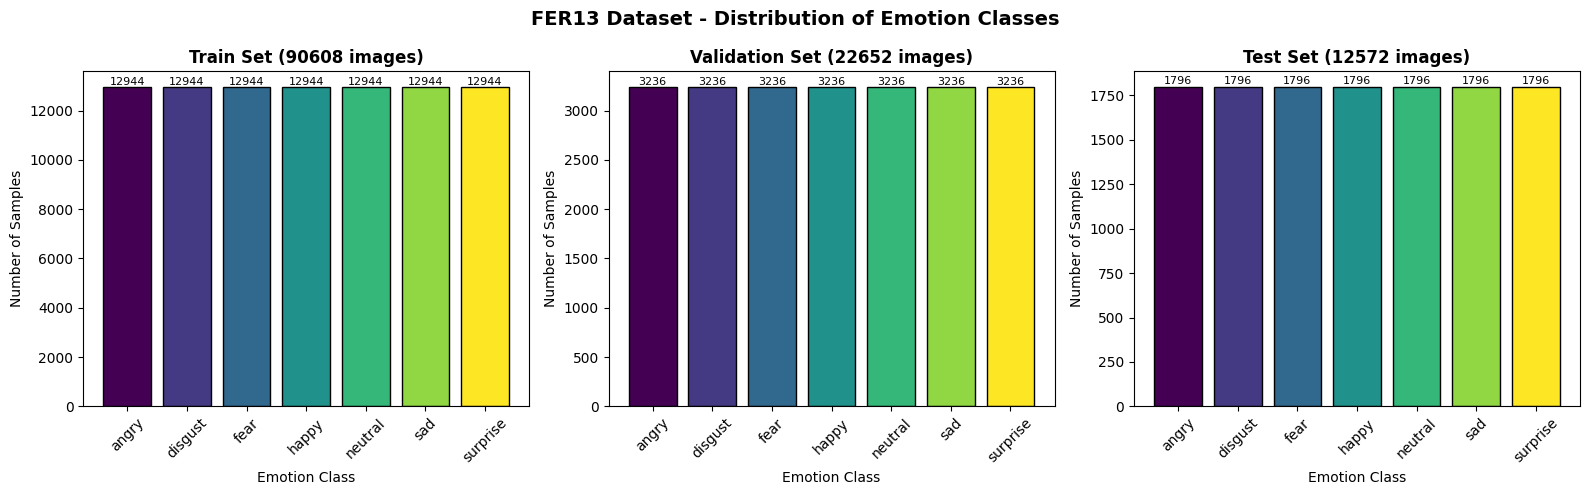


Detailed Sample Counts:
--------------------------------------------------
Emotion           Train   Validation       Test
--------------------------------------------------
angry             12944         3236       1796
disgust           12944         3236       1796
fear              12944         3236       1796
happy             12944         3236       1796
neutral           12944         3236       1796
sad               12944         3236       1796
surprise          12944         3236       1796


In [3]:
# Display dataset distribution for each split
def plot_dataset_distribution(train_labels, val_labels, test_labels, emotions):
    """Plot the distribution of samples across emotion classes for all splits."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    splits = [('Train', train_labels), ('Validation', val_labels), ('Test', test_labels)]
    colors = plt.cm.viridis(np.linspace(0, 1, len(emotions)))
    
    for ax, (split_name, labels) in zip(axes, splits):
        counts = [labels.count(emotion) for emotion in emotions]
        bars = ax.bar(emotions, counts, color=colors, edgecolor='black')
        ax.set_xlabel('Emotion Class', fontsize=10)
        ax.set_ylabel('Number of Samples', fontsize=10)
        ax.set_title(f'{split_name} Set ({sum(counts)} images)', fontsize=12, fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for bar, count in zip(bars, counts):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    str(count), ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('FER13 Dataset - Distribution of Emotion Classes', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return

plot_dataset_distribution(train_labels, val_labels, test_labels, EMOTIONS)

# Print detailed counts
print("\nDetailed Sample Counts:")
print("-"*50)
print(f"{'Emotion':<12} {'Train':>10} {'Validation':>12} {'Test':>10}")
print("-"*50)
for emotion in EMOTIONS:
    train_count = train_labels.count(emotion)
    val_count = val_labels.count(emotion)
    test_count = test_labels.count(emotion)
    print(f"{emotion:<12} {train_count:>10} {val_count:>12} {test_count:>10}")

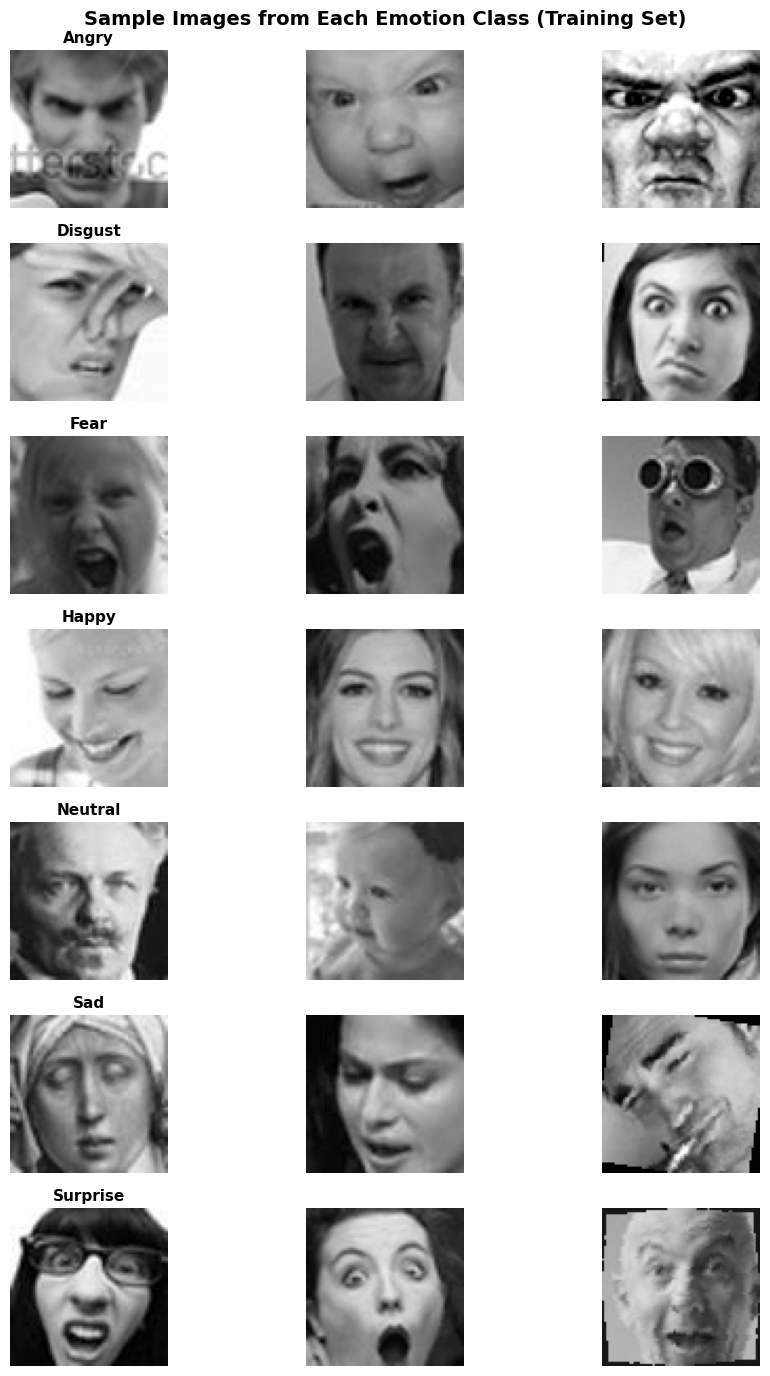

In [4]:
# Display sample images from each emotion class (from training set)
def display_sample_images(images, labels, emotions, samples_per_class=3):
    """Display sample images from each emotion class."""
    n_emotions = len(emotions)
    fig, axes = plt.subplots(n_emotions, samples_per_class, figsize=(10, 14))
    
    for i, emotion in enumerate(emotions):
        # Get indices for this emotion
        indices = [j for j, label in enumerate(labels) if label == emotion]
        
        if len(indices) == 0:
            for j in range(samples_per_class):
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_title(f'{emotion} (no images)', fontsize=10)
            continue
            
        # Select random samples
        sample_indices = np.random.choice(indices, min(samples_per_class, len(indices)), replace=False)
        
        for j, idx in enumerate(sample_indices):
            # Handle both grayscale and color images
            if len(images[idx].shape) == 2:
                axes[i, j].imshow(images[idx], cmap='gray')
            else:
                img_rgb = cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB)
                axes[i, j].imshow(img_rgb)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(emotion.capitalize(), fontsize=11, fontweight='bold')
    
    plt.suptitle('Sample Images from Each Emotion Class (Training Set)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

if len(train_images) > 0:
    display_sample_images(train_images, train_labels, EMOTIONS)
else:
    print("No training images loaded. Please check the dataset path.")

## 3. Face Detection Using Viola–Jones Algorithm

The **Viola–Jones** framework is a robust face detection algorithm that includes:
- **Haar feature selection**: Uses rectangular features to encode facial characteristics
- **Integral image computation**: Enables fast feature evaluation
- **AdaBoost**: Selects strong features from a large pool
- **Cascade classifiers**: Enables fast rejection of non-face regions

Detection is performed on grayscale images using OpenCV's `CascadeClassifier`.

In [5]:
# Load Haar Cascade classifier for face detection (Viola-Jones)
# OpenCV provides pre-trained Haar cascade classifiers
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_face_viola_jones(image, face_cascade):
    """
    Detect face in an image using Viola-Jones algorithm.
    
    Parameters:
    -----------
    image : numpy array
        Input image (BGR format)
    face_cascade : cv2.CascadeClassifier
        Pre-trained Haar cascade classifier
        
    Returns:
    --------
    face_region : numpy array or None
        Detected face region (grayscale) or None if no face detected
    """
    # Convert to grayscale (Viola-Jones works on grayscale)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces using Viola-Jones
    # Parameters: scaleFactor, minNeighbors, minSize
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    
    if len(faces) > 0:
        # Take the largest face detected
        (x, y, w, h) = max(faces, key=lambda rect: rect[2] * rect[3])
        face_region = gray[y:y+h, x:x+w]
        return face_region
    else:
        # If no face detected, return the whole image converted to grayscale
        return gray
    
print("Viola-Jones Face Detector loaded successfully!")
print(f"Haar Cascade path: {cv2.data.haarcascades}")

Viola-Jones Face Detector loaded successfully!
Haar Cascade path: c:\Users\Zayani\AppData\Local\Programs\Python\Python311\Lib\site-packages\cv2\data\


In [6]:
# Detect faces in all images for each split
def detect_all_faces(images, labels, face_cascade):
    """
    Apply Viola-Jones face detection to all images.
    
    Returns:
    --------
    detected_faces : list of numpy arrays
        List of detected face regions (grayscale)
    valid_labels : list
        Corresponding labels for detected faces
    """
    detected_faces = []
    valid_labels = []
    
    for i, (img, label) in enumerate(zip(images, labels)):
        face = detect_face_viola_jones(img, face_cascade)
        if face is not None:
            detected_faces.append(face)
            valid_labels.append(label)
        
        # Progress update
        if (i + 1) % 1000 == 0:
            print(f"  Processed {i + 1}/{len(images)} images...")
    
    return detected_faces, valid_labels

# Apply face detection to all splits
print("Detecting faces using Viola-Jones algorithm...")
print("="*60)

print("\n🔍 Processing TRAINING set...")
train_faces, train_face_labels = detect_all_faces(train_images, train_labels, face_cascade)
print(f"  Detected: {len(train_faces)}/{len(train_images)} faces")

print("\n🔍 Processing VALIDATION set...")
val_faces, val_face_labels = detect_all_faces(val_images, val_labels, face_cascade)
print(f"  Detected: {len(val_faces)}/{len(val_images)} faces")

print("\n🔍 Processing TEST set...")
test_faces, test_face_labels = detect_all_faces(test_images, test_labels, face_cascade)
print(f"  Detected: {len(test_faces)}/{len(test_images)} faces")

print("\n" + "="*60)
print("Face detection complete!")

Detecting faces using Viola-Jones algorithm...

🔍 Processing TRAINING set...
  Processed 1000/90608 images...
  Processed 2000/90608 images...
  Processed 3000/90608 images...
  Processed 4000/90608 images...
  Processed 5000/90608 images...
  Processed 6000/90608 images...
  Processed 7000/90608 images...
  Processed 8000/90608 images...
  Processed 9000/90608 images...
  Processed 10000/90608 images...
  Processed 11000/90608 images...
  Processed 12000/90608 images...
  Processed 13000/90608 images...
  Processed 14000/90608 images...
  Processed 15000/90608 images...
  Processed 16000/90608 images...
  Processed 17000/90608 images...
  Processed 18000/90608 images...
  Processed 19000/90608 images...
  Processed 20000/90608 images...
  Processed 21000/90608 images...
  Processed 22000/90608 images...
  Processed 23000/90608 images...
  Processed 24000/90608 images...
  Processed 25000/90608 images...
  Processed 26000/90608 images...
  Processed 27000/90608 images...
  Processed 28

## 4. Preprocess Detected Faces

Preprocessing steps:
1. **Resize** all detected face regions to a uniform **64×64** pixel size
2. **Histogram Equalization** for contrast normalization
3. Store preprocessed faces with their corresponding emotion labels

In [7]:
# Preprocessing parameters
IMG_SIZE = 64  # Target size: 64x64 pixels

def preprocess_face(face, img_size=64):
    """
    Preprocess a detected face region.
    """
    # Resize to target size
    resized = cv2.resize(face, (img_size, img_size))
    
    # Apply histogram equalization for contrast normalization
    equalized = cv2.equalizeHist(resized)
    
    return equalized

def preprocess_all_faces(detected_faces, img_size=64):
    """
    Preprocess all detected faces.
    """
    preprocessed = []
    for face in detected_faces:
        processed = preprocess_face(face, img_size)
        preprocessed.append(processed)
    return preprocessed

# Preprocess all splits
print(f"Preprocessing faces to {IMG_SIZE}x{IMG_SIZE}...")
print("="*60)

train_preprocessed = preprocess_all_faces(train_faces, IMG_SIZE)
print(f"Training set:   {len(train_preprocessed)} faces preprocessed")

val_preprocessed = preprocess_all_faces(val_faces, IMG_SIZE)
print(f"Validation set: {len(val_preprocessed)} faces preprocessed")

test_preprocessed = preprocess_all_faces(test_faces, IMG_SIZE)
print(f"Test set:       {len(test_preprocessed)} faces preprocessed")

print("="*60)
print("Preprocessing complete!")

Preprocessing faces to 64x64...
Training set:   90608 faces preprocessed
Validation set: 22652 faces preprocessed
Test set:       12572 faces preprocessed
Preprocessing complete!


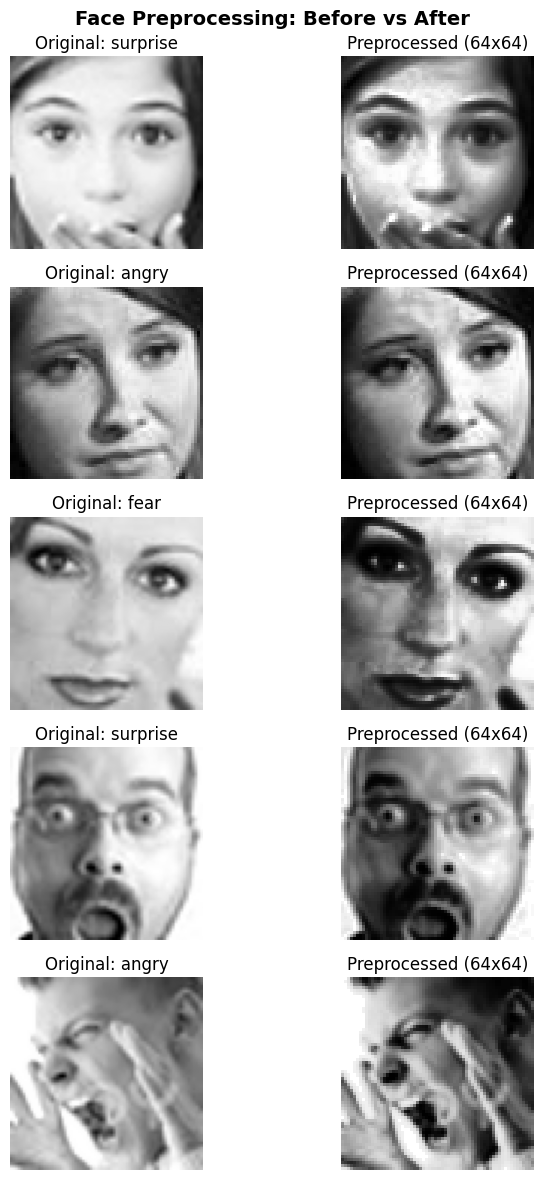

In [8]:
# Visualize preprocessing results
def visualize_preprocessing(detected_faces, preprocessed_faces, valid_labels, n_samples=5):
    """Display before and after preprocessing comparison."""
    if len(detected_faces) == 0:
        print("No faces available to visualize.")
        return
        
    fig, axes = plt.subplots(n_samples, 2, figsize=(8, 12))
    
    indices = np.random.choice(len(detected_faces), min(n_samples, len(detected_faces)), replace=False)
    
    for i, idx in enumerate(indices):
        # Original detected face
        axes[i, 0].imshow(detected_faces[idx], cmap='gray')
        axes[i, 0].set_title(f'Original: {valid_labels[idx]}')
        axes[i, 0].axis('off')
        
        # Preprocessed face
        axes[i, 1].imshow(preprocessed_faces[idx], cmap='gray')
        axes[i, 1].set_title(f'Preprocessed ({IMG_SIZE}x{IMG_SIZE})')
        axes[i, 1].axis('off')
    
    plt.suptitle('Face Preprocessing: Before vs After', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

if len(train_preprocessed) > 0:
    visualize_preprocessing(train_faces, train_preprocessed, train_face_labels)
else:
    print("No preprocessed faces available.")

## 5. System 1: Extract Raw Pixel Features

**System 1** uses raw pixel values as features:
- Each 64×64 grayscale face image is flattened into a **4096-dimensional** feature vector
- Simple but effective approach that captures direct intensity information

In [9]:
# Extract raw pixel features (System 1)
def extract_pixel_features(preprocessed_faces):
    """
    Extract raw pixel features by flattening each face image.
    64x64 image -> 4096-dimensional feature vector
    """
    n_samples = len(preprocessed_faces)
    n_features = IMG_SIZE * IMG_SIZE  # 64*64 = 4096
    
    X_pixels = np.zeros((n_samples, n_features))
    
    for i, face in enumerate(preprocessed_faces):
        X_pixels[i] = face.flatten()
    
    # Normalize pixel values to [0, 1]
    X_pixels = X_pixels / 255.0
    
    return X_pixels

# Extract raw pixel features for all splits
print("="*50)
print("SYSTEM 1: Raw Pixel Features")
print("="*50)

X_pixels_train = extract_pixel_features(train_preprocessed)
X_pixels_val = extract_pixel_features(val_preprocessed)
X_pixels_test = extract_pixel_features(test_preprocessed)

print(f"Training features shape:   {X_pixels_train.shape}")
print(f"Validation features shape: {X_pixels_val.shape}")
print(f"Test features shape:       {X_pixels_test.shape}")
print(f"Number of features: {X_pixels_train.shape[1]} (64 x 64 = 4096)")

SYSTEM 1: Raw Pixel Features
Training features shape:   (90608, 4096)
Validation features shape: (22652, 4096)
Test features shape:       (12572, 4096)
Number of features: 4096 (64 x 64 = 4096)


## 6. System 2: Extract HOG Features

**Histogram of Oriented Gradients (HOG)** captures edge and gradient structure:

**Extraction Procedure:**
1. Resize face to 64×64
2. Divide into 8×8 overlapping blocks
3. Compute a 9-bin histogram per block
4. Concatenate into a **1764-dimensional** feature vector

HOG is robust to illumination changes and captures shape information effectively.

In [10]:
! pip install tqdm

In [11]:
# Extract HOG features (System 2)
import numpy as np
from skimage.feature import hog
from joblib import Parallel, delayed
from tqdm import tqdm
def hog_single(face, visualize=False):
    """
    Extract HOG from a single face image.
    """
    return hog(
        face,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=visualize,
        block_norm='L2-Hys'
    )


def extract_hog_features(faces, visualize=False):
    """
    Extract HOG features from a list of preprocessed faces.
    Uses ALL CPU cores for speed.
    """

    print(f"\nExtracting HOG features... (visualize={visualize})")

    # Parallel processing
    results = Parallel(n_jobs=-1)(
        delayed(hog_single)(face, visualize)
        for face in tqdm(faces, desc="HOG extraction")
    )

    if visualize:
        # results = (features, hog_image)
        features = [r[0] for r in results]
        hog_images = [r[1] for r in results]
        return np.array(features), hog_images

    else:
        # results = features only
        return np.array(results), None


# ============================================================
#  RUN HOG EXTRACTION FOR TRAIN / VAL / TEST
# ============================================================

print("="*60)
print("SYSTEM 2 — HOG FEATURE EXTRACTION (OPTIMIZED)")
print("="*60)

# TRAIN
X_hog_train, _ = extract_hog_features(train_preprocessed, visualize=False)

# VALIDATION
X_hog_val, _ = extract_hog_features(val_preprocessed, visualize=False)

# TEST
X_hog_test, _ = extract_hog_features(test_preprocessed, visualize=False)


# ============================================================
#  RESULTS SUMMARY
# ============================================================

print("\n=== HOG FEATURES SUMMARY ===")
print(f"Training set shape:     {X_hog_train.shape}")
print(f"Validation set shape:   {X_hog_val.shape}")
print(f"Test set shape:         {X_hog_test.shape}")

print(f"\nNumber of HOG features per image: {X_hog_train.shape[1]}")

SYSTEM 2 — HOG FEATURE EXTRACTION (OPTIMIZED)

Extracting HOG features... (visualize=False)


HOG extraction: 100%|██████████| 90608/90608 [00:21<00:00, 4161.25it/s]



Extracting HOG features... (visualize=False)


HOG extraction: 100%|██████████| 22652/22652 [00:04<00:00, 4883.34it/s]



Extracting HOG features... (visualize=False)


HOG extraction: 100%|██████████| 12572/12572 [00:02<00:00, 4410.60it/s]



=== HOG FEATURES SUMMARY ===
Training set shape:     (90608, 1764)
Validation set shape:   (22652, 1764)
Test set shape:         (12572, 1764)

Number of HOG features per image: 1764


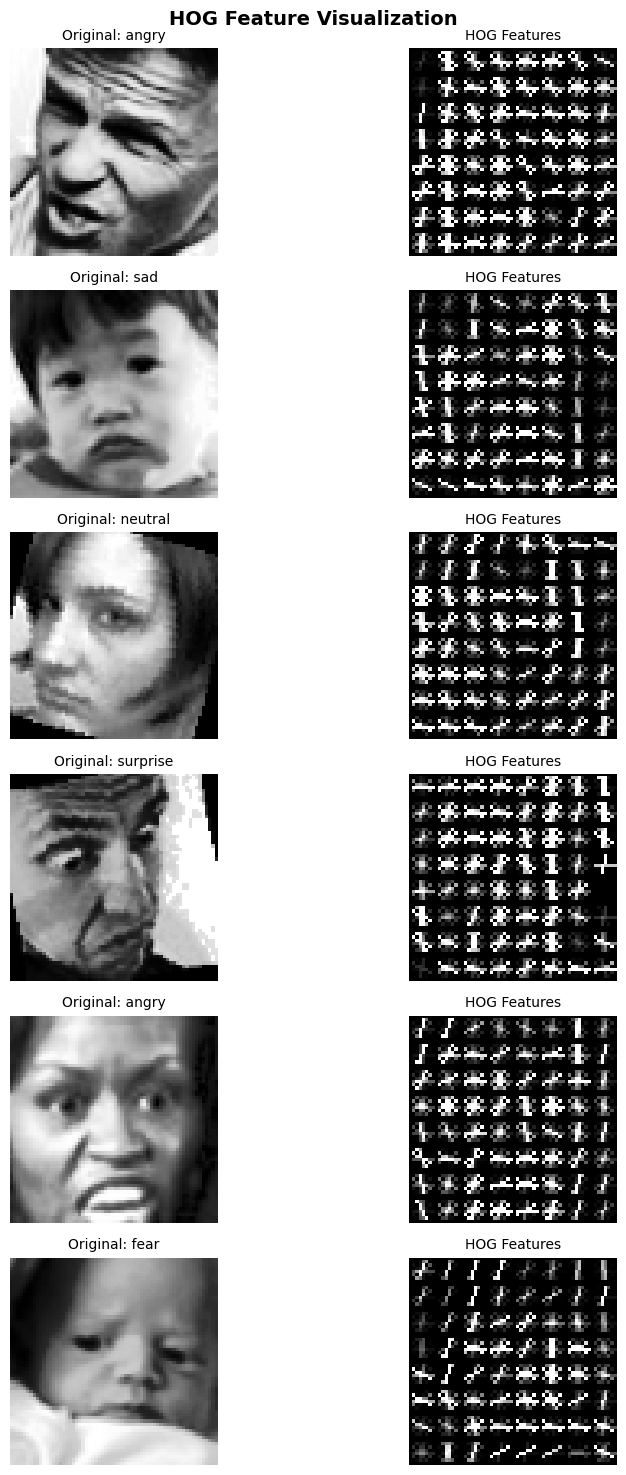

In [12]:
# Visualize HOG features
def visualize_hog_features(preprocessed_faces, valid_labels, n_samples=6):
    """Display original faces alongside their HOG visualizations."""
    if len(preprocessed_faces) == 0:
        print("No faces available to visualize.")
        return
        
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 15))
    
    indices = np.random.choice(len(preprocessed_faces), min(n_samples, len(preprocessed_faces)), replace=False)
    
    for i, idx in enumerate(indices):
        # Original face
        axes[i, 0].imshow(preprocessed_faces[idx], cmap='gray')
        axes[i, 0].set_title(f'Original: {valid_labels[idx]}', fontsize=10)
        axes[i, 0].axis('off')
        
        # Extract HOG with visualization for this sample
        _, hog_image = hog(
            preprocessed_faces[idx],
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            block_norm='L2-Hys'
        )
        
        hog_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        axes[i, 1].imshow(hog_rescaled, cmap='gray')
        axes[i, 1].set_title('HOG Features', fontsize=10)
        axes[i, 1].axis('off')
    
    plt.suptitle('HOG Feature Visualization', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

if len(train_preprocessed) > 0:
    visualize_hog_features(train_preprocessed, train_face_labels)
else:
    print("No preprocessed faces available.")

## 7. Encode Labels

Encode the emotion labels for classification. The dataset already has train/test/validation splits, so we don't need to split the data.

In [13]:
# Encode labels
label_encoder = LabelEncoder()

# Fit on all possible emotions
label_encoder.fit(EMOTIONS)

# Transform labels for each split
y_train = label_encoder.transform(train_face_labels)
y_val = label_encoder.transform(val_face_labels)
y_test = label_encoder.transform(test_face_labels)

print("Label Encoding:")
for i, emotion in enumerate(label_encoder.classes_):
    print(f"  {emotion} -> {i}")

print("\n" + "="*50)
print("Dataset Summary (After Face Detection)")
print("="*50)
print(f"\nTraining set:   {len(y_train)} samples")
print(f"Validation set: {len(y_val)} samples")
print(f"Test set:       {len(y_test)} samples")
print(f"Total:          {len(y_train) + len(y_val) + len(y_test)} samples")

Label Encoding:
  angry -> 0
  disgust -> 1
  fear -> 2
  happy -> 3
  neutral -> 4
  sad -> 5
  surprise -> 6

Dataset Summary (After Face Detection)

Training set:   90608 samples
Validation set: 22652 samples
Test set:       12572 samples
Total:          125832 samples


## 7.5 Apply PCA for Dimensionality Reduction (Optional)

**Principal Component Analysis (PCA)** reduces feature dimensions while preserving variance:
- Speeds up SVM training significantly
- Reduces overfitting by removing noise
- We retain components that explain **95%** of the variance

In [14]:
# Apply PCA for dimensionality reduction
from sklearn.decomposition import PCA

# ============================================================
# PCA CONFIGURATION
# ============================================================
USE_PCA = True  # Set to False to skip PCA
PCA_VARIANCE = 0.95  # Retain 95% of variance

if USE_PCA:
    print("="*60)
    print("APPLYING PCA FOR DIMENSIONALITY REDUCTION")
    print("="*60)
    
    # PCA for Raw Pixel Features (System 1)
    print("\n📊 System 1 (Raw Pixels):")
    print(f"  Original dimensions: {X_pixels_train.shape[1]}")
    
    pca_pixels = PCA(n_components=PCA_VARIANCE, random_state=42)
    X_pixels_train_pca = pca_pixels.fit_transform(X_pixels_train)
    X_pixels_val_pca = pca_pixels.transform(X_pixels_val)
    X_pixels_test_pca = pca_pixels.transform(X_pixels_test)
    
    print(f"  Reduced dimensions:  {X_pixels_train_pca.shape[1]}")
    print(f"  Variance retained:   {pca_pixels.explained_variance_ratio_.sum()*100:.1f}%")
    print(f"  Reduction ratio:     {X_pixels_train.shape[1]/X_pixels_train_pca.shape[1]:.1f}x")
    
    # PCA for HOG Features (System 2)
    print("\n📊 System 2 (HOG):")
    print(f"  Original dimensions: {X_hog_train.shape[1]}")
    
    pca_hog = PCA(n_components=PCA_VARIANCE, random_state=42)
    X_hog_train_pca = pca_hog.fit_transform(X_hog_train)
    X_hog_val_pca = pca_hog.transform(X_hog_val)
    X_hog_test_pca = pca_hog.transform(X_hog_test)
    
    print(f"  Reduced dimensions:  {X_hog_train_pca.shape[1]}")
    print(f"  Variance retained:   {pca_hog.explained_variance_ratio_.sum()*100:.1f}%")
    print(f"  Reduction ratio:     {X_hog_train.shape[1]/X_hog_train_pca.shape[1]:.1f}x")
    
    # Use PCA-reduced features for training
    X_pixels_train_final = X_pixels_train_pca
    X_pixels_test_final = X_pixels_test_pca
    X_hog_train_final = X_hog_train_pca
    X_hog_test_final = X_hog_test_pca
    
    print("\n✅ PCA applied! Using reduced features for SVM training.")
else:
    # Use original features
    X_pixels_train_final = X_pixels_train
    X_pixels_test_final = X_pixels_test
    X_hog_train_final = X_hog_train
    X_hog_test_final = X_hog_test
    print("PCA skipped. Using original features.")

APPLYING PCA FOR DIMENSIONALITY REDUCTION

📊 System 1 (Raw Pixels):
  Original dimensions: 4096
  Reduced dimensions:  295
  Variance retained:   95.0%
  Reduction ratio:     13.9x

📊 System 2 (HOG):
  Original dimensions: 1764
  Reduced dimensions:  471
  Variance retained:   95.0%
  Reduction ratio:     3.7x

✅ PCA applied! Using reduced features for SVM training.


## 8. Train SVM Classifiers with Different Kernels

Training Support Vector Machines with three kernel types:

1. **Linear Kernel**: $k(x_i, x_j) = x_i^T x_j$

2. **Polynomial Kernel**: $k(x_i, x_j) = (\gamma x_i^T x_j + r)^d$

3. **RBF Kernel**: $k(x_i, x_j) = \exp(-\gamma ||x_i - x_j||^2)$

Hyperparameters (C, γ, r, d) are tuned empirically for optimal performance.

In [15]:
# Define SVM configuration (OPTIMIZED FOR SPEED - LinearSVC only)
import time

def get_svm_classifiers():
    from sklearn.svm import LinearSVC
    return {
        'Linear': LinearSVC(
            C=1.0,
            class_weight="balanced",
            random_state=42,
            max_iter=10000,
            dual='auto'
        )
    }

def train_and_evaluate_svm(X_train, X_test, y_train, y_test, classifiers, system_name):
    """
    Train and evaluate SVM classifiers with timing information.
    """
    results = {}
    trained_models = {}
    
    print(f"\n{'='*60}")
    print(f"Training and Evaluating {system_name}")
    print(f"{'='*60}")
    
    total_start = time.time()
    
    for kernel_name, clf in classifiers.items():
        print(f"\n⏳ Training SVM with {kernel_name} kernel...")
        start_time = time.time()
        
        # Train
        clf.fit(X_train, y_train)
        trained_models[kernel_name] = clf
        
        train_time = time.time() - start_time
        
        # Predict
        y_pred = clf.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        results[kernel_name] = {
            'accuracy': accuracy,
            'predictions': y_pred,
            'classification_report': classification_report(y_test, y_pred, target_names=label_encoder.classes_)
        }
        
        print(f"  ✅ Accuracy: {accuracy * 100:.2f}% (trained in {train_time:.1f}s)")
    
    total_time = time.time() - total_start
    print(f"\n⏱️ Total training time: {total_time:.1f}s")
    
    return results, trained_models

print("SVM Classifier: LinearSVC (FAST)")
print("  - Uses optimized linear solver")
print("  - class_weight='balanced' for imbalanced classes")

SVM Classifier: LinearSVC (FAST)
  - Uses optimized linear solver
  - class_weight='balanced' for imbalanced classes


## 9. Evaluate System 1 (Raw Pixels + SVM)

Evaluate SVM classifiers trained on **raw pixel features** (4096 dimensions).

In [16]:
# Train and evaluate System 1 (Raw Pixels) - Uses PCA if enabled
classifiers_system1 = get_svm_classifiers()
results_system1, models_system1 = train_and_evaluate_svm(
    X_pixels_train_final, X_pixels_test_final, y_train, y_test,
    classifiers_system1, "SYSTEM 1: Raw Pixel Features" + (" + PCA" if USE_PCA else "")
)

# Find best kernel for System 1
best_kernel_s1 = max(results_system1, key=lambda k: results_system1[k]['accuracy'])
best_accuracy_s1 = results_system1[best_kernel_s1]['accuracy']

print(f"\n{'='*60}")
print(f"SYSTEM 1 BEST RESULT: {best_kernel_s1} kernel with {best_accuracy_s1*100:.2f}% accuracy")
print(f"{'='*60}")


Training and Evaluating SYSTEM 1: Raw Pixel Features + PCA

⏳ Training SVM with Linear kernel...
  ✅ Accuracy: 34.41% (trained in 42.7s)

⏱️ Total training time: 42.7s

SYSTEM 1 BEST RESULT: Linear kernel with 34.41% accuracy



Classification Report - System 1 (Linear Kernel):
              precision    recall  f1-score   support

       angry       0.29      0.18      0.22      1796
     disgust       0.38      0.55      0.45      1796
        fear       0.24      0.07      0.11      1796
       happy       0.38      0.57      0.45      1796
     neutral       0.31      0.28      0.29      1796
         sad       0.26      0.18      0.21      1796
    surprise       0.38      0.57      0.45      1796

    accuracy                           0.34     12572
   macro avg       0.32      0.34      0.31     12572
weighted avg       0.32      0.34      0.31     12572



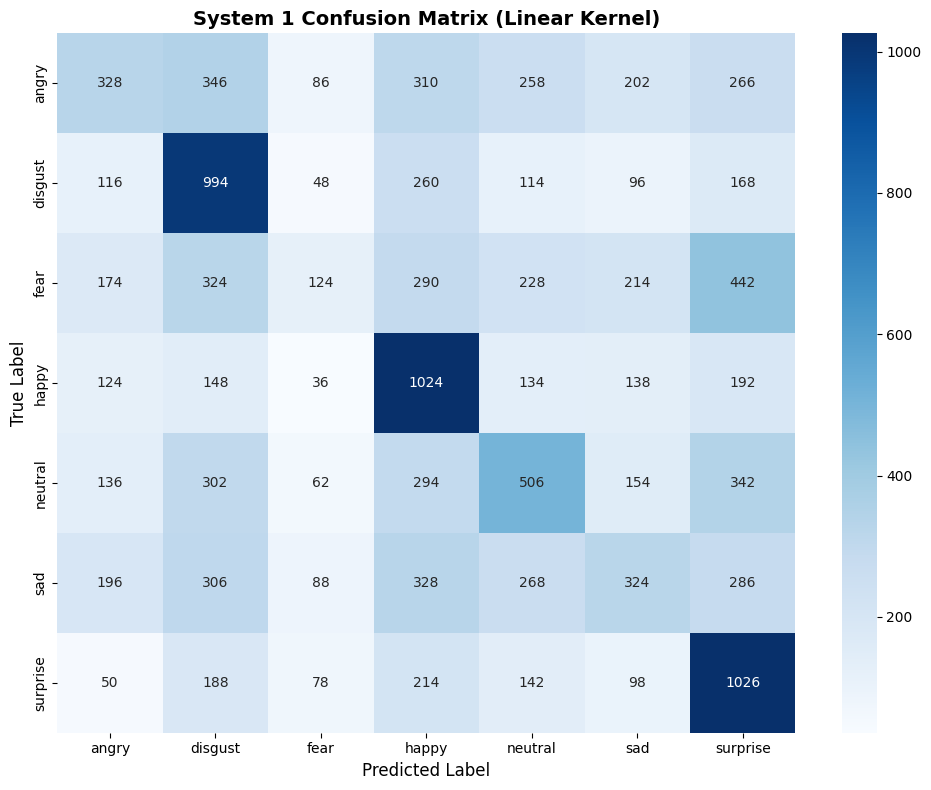

In [17]:
# Display classification report for best System 1 model
print(f"\nClassification Report - System 1 ({best_kernel_s1} Kernel):")
print("="*60)
print(results_system1[best_kernel_s1]['classification_report'])

# Plot confusion matrix for System 1
def plot_confusion_matrix(y_true, y_pred, classes, title):
    """Plot confusion matrix using seaborn."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return cm

# Plot confusion matrix for best System 1 model
cm_system1 = plot_confusion_matrix(
    y_test, results_system1[best_kernel_s1]['predictions'],
    label_encoder.classes_,
    f'System 1 Confusion Matrix ({best_kernel_s1} Kernel)'
)

## 10. Evaluate System 2 (HOG + SVM)

Evaluate SVM classifiers trained on **HOG features** (1764 dimensions).

In [18]:
# Train and evaluate System 2 (HOG Features) - Uses PCA if enabled
classifiers_system2 = get_svm_classifiers()
results_system2, models_system2 = train_and_evaluate_svm(
    X_hog_train_final, X_hog_test_final, y_train, y_test,
    classifiers_system2, "SYSTEM 2: HOG Features" + (" + PCA" if USE_PCA else "")
)

# Find best kernel for System 2
best_kernel_s2 = max(results_system2, key=lambda k: results_system2[k]['accuracy'])
best_accuracy_s2 = results_system2[best_kernel_s2]['accuracy']

print(f"\n{'='*60}")
print(f"SYSTEM 2 BEST RESULT: {best_kernel_s2} kernel with {best_accuracy_s2*100:.2f}% accuracy")
print(f"{'='*60}")


Training and Evaluating SYSTEM 2: HOG Features + PCA

⏳ Training SVM with Linear kernel...
  ✅ Accuracy: 43.38% (trained in 37.4s)

⏱️ Total training time: 37.4s

SYSTEM 2 BEST RESULT: Linear kernel with 43.38% accuracy



Classification Report - System 2 (Linear Kernel):
              precision    recall  f1-score   support

       angry       0.36      0.23      0.28      1796
     disgust       0.49      0.68      0.57      1796
        fear       0.33      0.15      0.21      1796
       happy       0.48      0.67      0.56      1796
     neutral       0.39      0.38      0.38      1796
         sad       0.32      0.25      0.28      1796
    surprise       0.49      0.68      0.57      1796

    accuracy                           0.43     12572
   macro avg       0.41      0.43      0.41     12572
weighted avg       0.41      0.43      0.41     12572



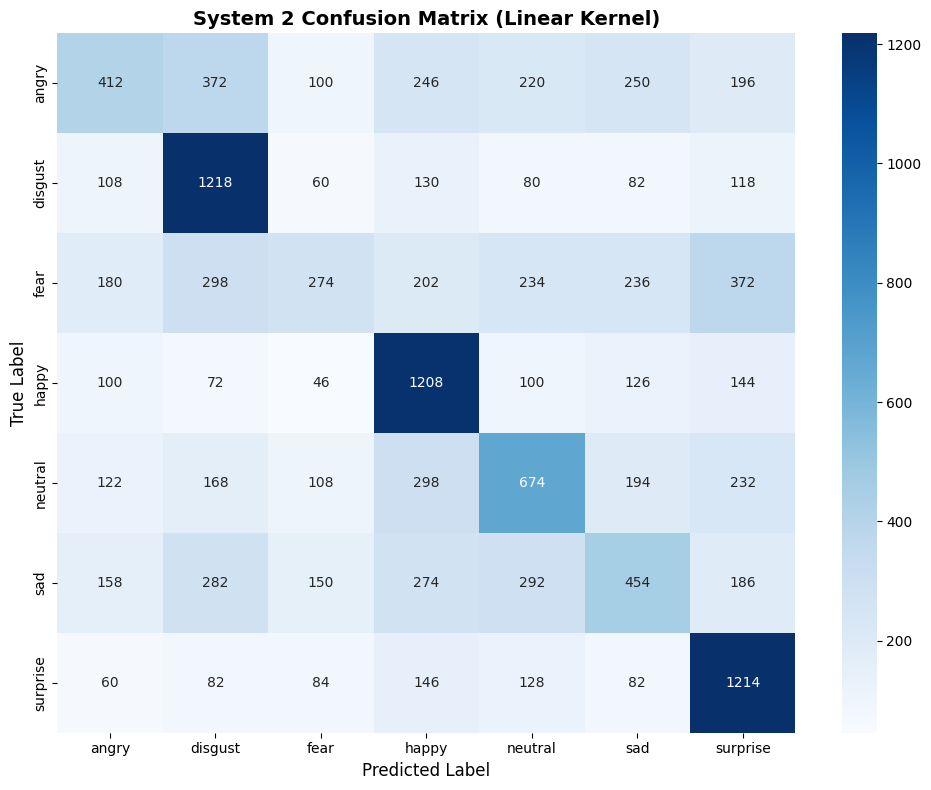

In [19]:
# Display classification report for best System 2 model
print(f"\nClassification Report - System 2 ({best_kernel_s2} Kernel):")
print("="*60)
print(results_system2[best_kernel_s2]['classification_report'])

# Plot confusion matrix for best System 2 model
cm_system2 = plot_confusion_matrix(
    y_test, results_system2[best_kernel_s2]['predictions'],
    label_encoder.classes_,
    f'System 2 Confusion Matrix ({best_kernel_s2} Kernel)'
)

## 11. Per-Emotion Accuracy Analysis

Calculate and display classification accuracy for each of the six emotions separately for both systems.

In [20]:
# Calculate per-emotion accuracy
def calculate_per_emotion_accuracy(y_true, y_pred, classes):
    """
    Calculate accuracy for each emotion class.
    
    Returns:
    --------
    per_emotion_acc : dict
        Dictionary with emotion names as keys and accuracy as values
    """
    per_emotion_acc = {}
    
    for i, emotion in enumerate(classes):
        # Get indices for this emotion
        mask = y_true == i
        if mask.sum() > 0:
            emotion_accuracy = (y_pred[mask] == y_true[mask]).mean() * 100
            per_emotion_acc[emotion] = emotion_accuracy
        else:
            per_emotion_acc[emotion] = 0.0
    
    return per_emotion_acc

# Calculate per-emotion accuracy for both systems
per_emotion_s1 = calculate_per_emotion_accuracy(
    y_test, results_system1[best_kernel_s1]['predictions'], 
    label_encoder.classes_
)

per_emotion_s2 = calculate_per_emotion_accuracy(
    y_test, results_system2[best_kernel_s2]['predictions'], 
    label_encoder.classes_
)

# Create comparison table
print("\n" + "="*70)
print("PER-EMOTION ACCURACY COMPARISON")
print("="*70)
print(f"\n{'Emotion':<15} {'System 1 (Pixels)':<20} {'System 2 (HOG)':<20}")
print("-"*55)
for emotion in label_encoder.classes_:
    print(f"{emotion:<15} {per_emotion_s1[emotion]:>15.2f}%     {per_emotion_s2[emotion]:>15.2f}%")
print("-"*55)
print(f"{'OVERALL':<15} {best_accuracy_s1*100:>15.2f}%     {best_accuracy_s2*100:>15.2f}%")


PER-EMOTION ACCURACY COMPARISON

Emotion         System 1 (Pixels)    System 2 (HOG)      
-------------------------------------------------------
angry                     18.26%               22.94%
disgust                   55.35%               67.82%
fear                       6.90%               15.26%
happy                     57.02%               67.26%
neutral                   28.17%               37.53%
sad                       18.04%               25.28%
surprise                  57.13%               67.59%
-------------------------------------------------------
OVERALL                   34.41%               43.38%


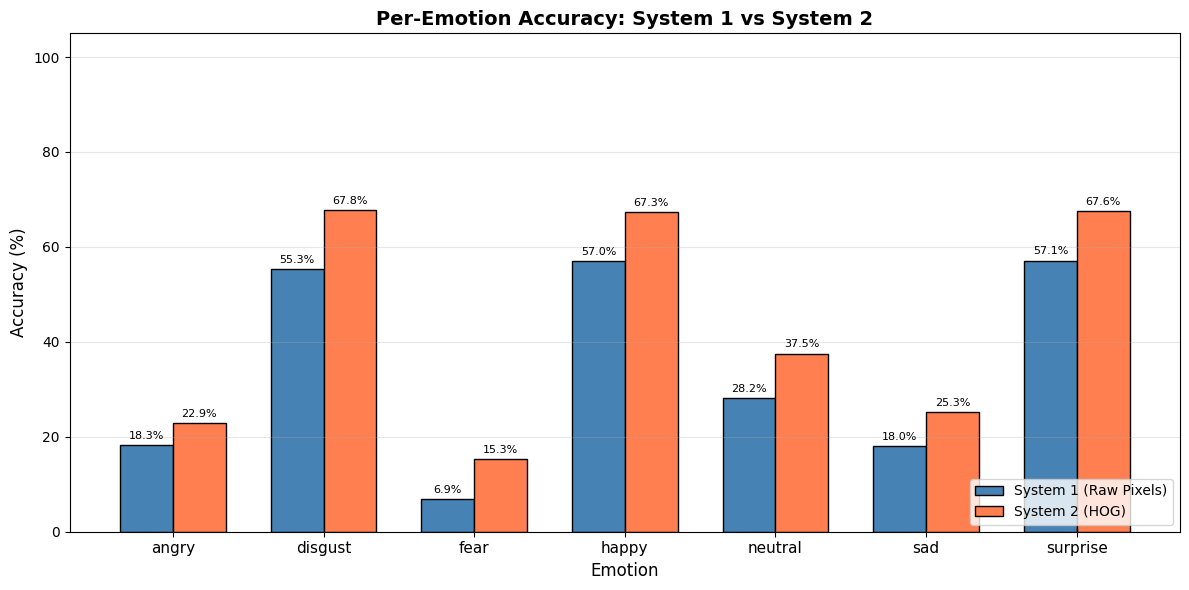

In [21]:
# Visualize per-emotion accuracy comparison
def plot_per_emotion_accuracy(per_emotion_s1, per_emotion_s2, emotions):
    """Create grouped bar chart for per-emotion accuracy comparison."""
    x = np.arange(len(emotions))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(x - width/2, [per_emotion_s1[e] for e in emotions], width, 
                   label='System 1 (Raw Pixels)', color='steelblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, [per_emotion_s2[e] for e in emotions], width, 
                   label='System 2 (HOG)', color='coral', edgecolor='black')
    
    ax.set_xlabel('Emotion', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Per-Emotion Accuracy: System 1 vs System 2', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(emotions, fontsize=11)
    ax.legend(loc='lower right', fontsize=10)
    ax.set_ylim([0, 105])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    
    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

plot_per_emotion_accuracy(per_emotion_s1, per_emotion_s2, label_encoder.classes_)

## 12. Compare Results Between Systems

Comprehensive comparison of System 1 (Raw Pixels) and System 2 (HOG) performance across all SVM kernels.

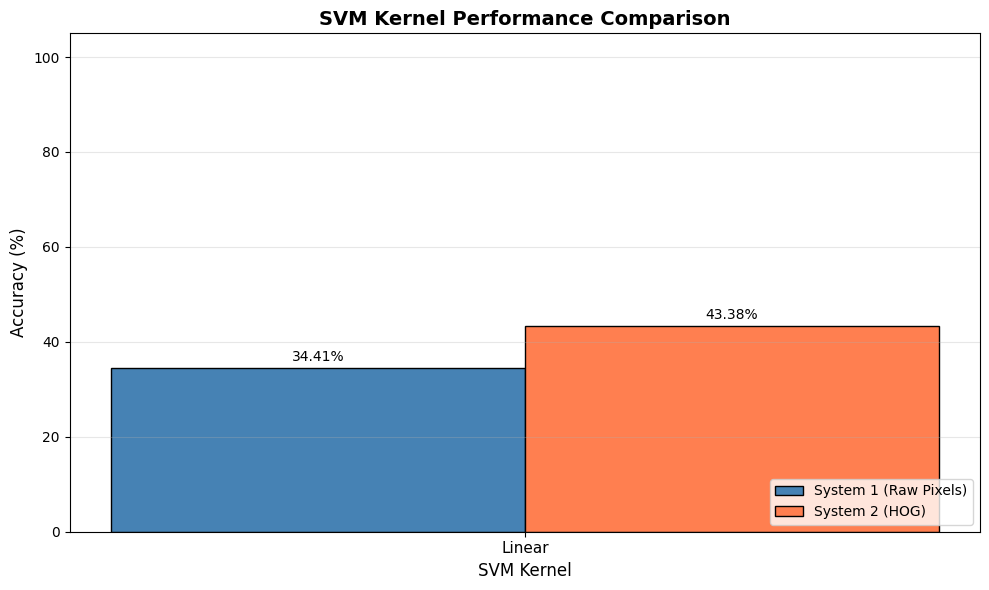

In [22]:
# Compare all kernels for both systems
def plot_kernel_comparison(results_s1, results_s2):
    """Create bar chart comparing all kernels for both systems."""
    kernels = list(results_s1.keys())
    
    acc_s1 = [results_s1[k]['accuracy'] * 100 for k in kernels]
    acc_s2 = [results_s2[k]['accuracy'] * 100 for k in kernels]
    
    x = np.arange(len(kernels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars1 = ax.bar(x - width/2, acc_s1, width, label='System 1 (Raw Pixels)', 
                   color='steelblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, acc_s2, width, label='System 2 (HOG)', 
                   color='coral', edgecolor='black')
    
    ax.set_xlabel('SVM Kernel', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('SVM Kernel Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(kernels, fontsize=11)
    ax.legend(loc='lower right', fontsize=10)
    ax.set_ylim([0, 105])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    
    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return kernels, acc_s1, acc_s2

kernels, acc_s1, acc_s2 = plot_kernel_comparison(results_system1, results_system2)

In [23]:
# Print comprehensive summary table
print("\n" + "="*70)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*70)

print("\n📊 ACCURACY BY KERNEL TYPE:")
print("-"*70)
print(f"{'Kernel':<15} {'System 1 (Pixels)':<25} {'System 2 (HOG)':<25}")
print("-"*70)
for kernel, a1, a2 in zip(kernels, acc_s1, acc_s2):
    print(f"{kernel:<15} {a1:>20.2f}%     {a2:>20.2f}%")

print("\n" + "="*70)
print("🏆 BEST RESULTS:")
print("="*70)
print(f"\n  System 1 (Raw Pixels):")
print(f"    Best Kernel: {best_kernel_s1}")
print(f"    Accuracy:    {best_accuracy_s1*100:.2f}%")
print(f"    Features:    4096 dimensions")

print(f"\n  System 2 (HOG Features):")
print(f"    Best Kernel: {best_kernel_s2}")
print(f"    Accuracy:    {best_accuracy_s2*100:.2f}%")
print(f"    Features:    {X_hog_train.shape[1]} dimensions")

print("\n" + "="*70)
if best_accuracy_s2 >= best_accuracy_s1:
    print("✅ WINNER: System 2 (HOG + SVM)")
    print(f"   HOG features provide {(best_accuracy_s2 - best_accuracy_s1)*100:.2f}% improvement")
else:
    print("✅ WINNER: System 1 (Raw Pixels + SVM)")
    print(f"   Raw pixels provide {(best_accuracy_s1 - best_accuracy_s2)*100:.2f}% improvement")
print("="*70)


COMPREHENSIVE RESULTS SUMMARY

📊 ACCURACY BY KERNEL TYPE:
----------------------------------------------------------------------
Kernel          System 1 (Pixels)         System 2 (HOG)           
----------------------------------------------------------------------
Linear                         34.41%                    43.38%

🏆 BEST RESULTS:

  System 1 (Raw Pixels):
    Best Kernel: Linear
    Accuracy:    34.41%
    Features:    4096 dimensions

  System 2 (HOG Features):
    Best Kernel: Linear
    Accuracy:    43.38%
    Features:    1764 dimensions

✅ WINNER: System 2 (HOG + SVM)
   HOG features provide 8.97% improvement


## 13. Test on Single Image

Test the trained model on a **new input image**:
1. Apply Viola-Jones face detection
2. Preprocess the detected face
3. Extract features (Raw Pixels or HOG)
4. Predict emotion using the best trained SVM model
5. Display the image with predicted emotion label

⚠️ **Update the `test_image_path` variable below to test on your own image.**

In [24]:
# Function to predict emotion from a single image
def predict_emotion(image_path, face_cascade, model, label_encoder, use_hog=True, img_size=64, pca_transformer=None):
    """
    Predict emotion from a single image.
    
    Parameters:
    -----------
    image_path : str
        Path to the input image
    face_cascade : cv2.CascadeClassifier
        Haar cascade classifier for face detection
    model : sklearn SVM classifier
        Trained SVM model
    label_encoder : LabelEncoder
        Fitted label encoder for emotion classes
    use_hog : bool
        If True, use HOG features; otherwise use raw pixels
    img_size : int
        Size to resize face (default: 64)
    pca_transformer : PCA object or None
        If PCA was used during training, pass the fitted PCA transformer
        
    Returns:
    --------
    emotion : str
        Predicted emotion label
    face_region : numpy array
        Detected and preprocessed face
    original_image : numpy array
        Original input image with face detection box
    bbox : tuple
        Bounding box coordinates (x, y, w, h)
    """
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    img_display = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect face using Viola-Jones
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )
    
    if len(faces) == 0:
        print("No face detected! Using entire image...")
        face_region = gray
        x, y, w, h = 0, 0, img.shape[1], img.shape[0]
    else:
        # Take the largest face
        (x, y, w, h) = max(faces, key=lambda rect: rect[2] * rect[3])
        face_region = gray[y:y+h, x:x+w]
        # Draw rectangle on display image
        cv2.rectangle(img_display, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Preprocess face
    face_resized = cv2.resize(face_region, (img_size, img_size))
    face_equalized = cv2.equalizeHist(face_resized)
    
    # Extract features
    if use_hog:
        features, _ = hog(
            face_equalized,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            block_norm='L2-Hys'
        )
        features = features.reshape(1, -1)
    else:
        features = face_equalized.flatten().reshape(1, -1) / 255.0
    
    # Apply PCA transformation if it was used during training
    if pca_transformer is not None:
        features = pca_transformer.transform(features)
    
    # Predict
    prediction = model.predict(features)[0]
    emotion = label_encoder.inverse_transform([prediction])[0]
    
    return emotion, face_equalized, img_display, (x, y, w, h)

print("Prediction function defined successfully!")

Prediction function defined successfully!


Using: System 2 (HOG + Linear SVM)
PCA enabled: True
Test image: C:\Users\Zayani\Downloads\istockphoto-1372641621-612x612 (1).jpg


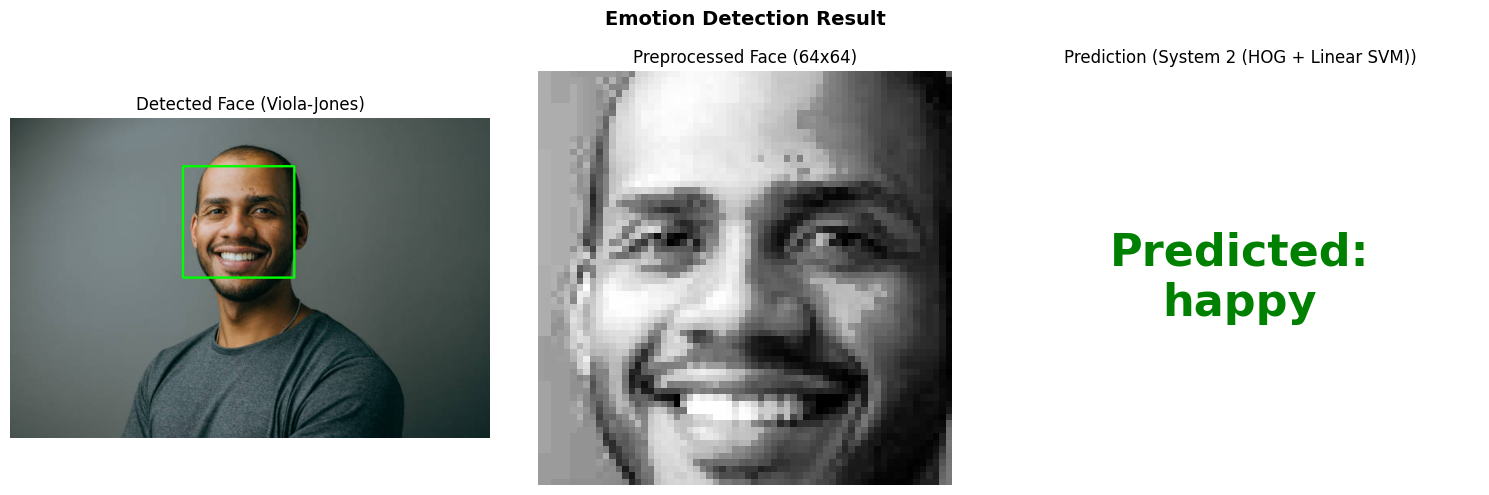


🎯 Predicted Emotion: happy


In [25]:
# ============================================================
# TEST ON A SINGLE IMAGE
# ============================================================
# UPDATE THIS PATH to test on your own image
test_image_path = r"C:\Users\Zayani\Downloads\istockphoto-1372641621-612x612 (1).jpg"  # <-- CHANGE THIS PATH

# Choose which system to use for prediction
USE_HOG = True  # True = System 2 (HOG), False = System 1 (Raw Pixels)

# Select the best model and PCA transformer based on the system
if USE_HOG:
    best_model = models_system2[best_kernel_s2]
    system_name = f"System 2 (HOG + {best_kernel_s2} SVM)"
    pca_transform = pca_hog if USE_PCA else None
else:
    best_model = models_system1[best_kernel_s1]
    system_name = f"System 1 (Pixels + {best_kernel_s1} SVM)"
    pca_transform = pca_pixels if USE_PCA else None

print(f"Using: {system_name}")
print(f"PCA enabled: {USE_PCA}")
print(f"Test image: {test_image_path}")

# Check if test image exists
if os.path.exists(test_image_path):
    try:
        # Make prediction (pass PCA transformer if PCA was used)
        emotion, face, img_with_box, bbox = predict_emotion(
            test_image_path, 
            face_cascade, 
            best_model, 
            label_encoder,
            use_hog=USE_HOG,
            pca_transformer=pca_transform
        )
        
        # Display results
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image with face detection
        img_rgb = cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB)
        axes[0].imshow(img_rgb)
        axes[0].set_title('Detected Face (Viola-Jones)', fontsize=12)
        axes[0].axis('off')
        
        # Preprocessed face
        axes[1].imshow(face, cmap='gray')
        axes[1].set_title('Preprocessed Face (64x64)', fontsize=12)
        axes[1].axis('off')
        
        # Prediction result
        axes[2].text(0.5, 0.5, f"Predicted:\n{emotion}", 
                     fontsize=32, ha='center', va='center', fontweight='bold',
                     color='green', transform=axes[2].transAxes)
        axes[2].set_title(f'Prediction ({system_name})', fontsize=12)
        axes[2].axis('off')
        
        plt.suptitle(f'Emotion Detection Result', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"\n🎯 Predicted Emotion: {emotion}")
        
    except Exception as e:
        print(f"Error processing image: {e}")
else:
    print(f"\n⚠️ Test image not found at: {test_image_path}")
    print("Please update the 'test_image_path' variable with a valid image path.")

Testing on a random sample from the test set...


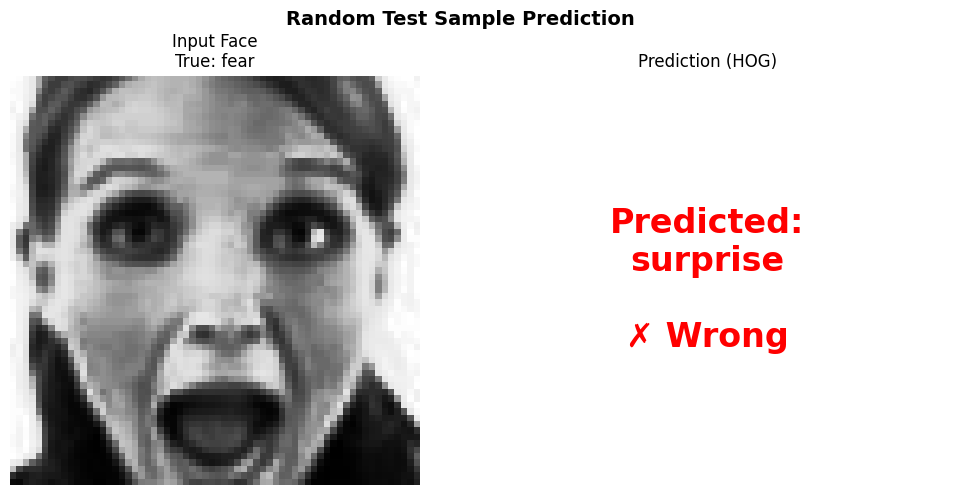


True Emotion: fear
Predicted Emotion: surprise
Result: ✗ Wrong


In [26]:
# ============================================================
# ALTERNATIVE: Test on a random image from the test set
# ============================================================
def test_on_random_sample(preprocessed_faces, face_labels, y_test_encoded, 
                           model, label_encoder, use_hog=True, pca_transformer=None):
    """Test model on a random sample from the test set."""
    
    # Get a random test sample index
    test_idx = np.random.randint(0, len(y_test_encoded))
    
    # Get the actual features based on system
    if use_hog:
        features = X_hog_test[test_idx].reshape(1, -1)
        system_name = "HOG"
    else:
        features = X_pixels_test[test_idx].reshape(1, -1)
        system_name = "Raw Pixels"
    
    # Apply PCA if used during training
    if pca_transformer is not None:
        features = pca_transformer.transform(features)
    
    # Predict
    prediction = model.predict(features)[0]
    predicted_emotion = label_encoder.inverse_transform([prediction])[0]
    true_emotion = label_encoder.inverse_transform([y_test_encoded[test_idx]])[0]
    
    # Display
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(preprocessed_faces[test_idx], cmap='gray')
    axes[0].set_title(f'Input Face\nTrue: {true_emotion}', fontsize=12)
    axes[0].axis('off')
    
    # Show prediction with color based on correctness
    color = 'green' if predicted_emotion == true_emotion else 'red'
    status = '✓ Correct' if predicted_emotion == true_emotion else '✗ Wrong'
    
    axes[1].text(0.5, 0.5, f"Predicted:\n{predicted_emotion}\n\n{status}", 
                 fontsize=24, ha='center', va='center', fontweight='bold',
                 color=color, transform=axes[1].transAxes)
    axes[1].set_title(f'Prediction ({system_name})', fontsize=12)
    axes[1].axis('off')
    
    plt.suptitle('Random Test Sample Prediction', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\nTrue Emotion: {true_emotion}")
    print(f"Predicted Emotion: {predicted_emotion}")
    print(f"Result: {status}")

# Test on random sample from test set
print("Testing on a random sample from the test set...")
if USE_HOG:
    pca_transform = pca_hog if USE_PCA else None
    test_on_random_sample(test_preprocessed, test_face_labels, y_test,
                          models_system2[best_kernel_s2], label_encoder, 
                          use_hog=True, pca_transformer=pca_transform)
else:
    pca_transform = pca_pixels if USE_PCA else None
    test_on_random_sample(test_preprocessed, test_face_labels, y_test,
                          models_system1[best_kernel_s1], label_encoder, 
                          use_hog=False, pca_transformer=pca_transform)

## 14. Save Trained Models (Optional)

Save the best trained models for future use without retraining.

In [27]:
# Save trained models using joblib
import joblib

# Create models directory
models_dir = os.path.join(os.path.dirname(DATASET_PATH) if os.path.exists(DATASET_PATH) else ".", "saved_models")
os.makedirs(models_dir, exist_ok=True)

# Save best models
model_s1_path = os.path.join(models_dir, f"system1_svm_{best_kernel_s1.lower()}.joblib")
model_s2_path = os.path.join(models_dir, f"system2_svm_{best_kernel_s2.lower()}.joblib")
encoder_path = os.path.join(models_dir, "label_encoder.joblib")

joblib.dump(models_system1[best_kernel_s1], model_s1_path)
joblib.dump(models_system2[best_kernel_s2], model_s2_path)
joblib.dump(label_encoder, encoder_path)

print("Models saved successfully!")
print(f"  System 1 model: {model_s1_path}")
print(f"  System 2 model: {model_s2_path}")
print(f"  Label encoder:  {encoder_path}")

print("\n" + "="*60)
print("To load models later:")
print("="*60)

#Load saved models
model_s1 = joblib.load('saved_models/system1_svm_rbf.joblib')
model_s2 = joblib.load('saved_models/system2_svm_rbf.joblib')
label_encoder = joblib.load('saved_models/label_encoder.joblib')

Models saved successfully!
  System 1 model: C:\Users\Zayani\Desktop\projet machine learning\saved_models\system1_svm_linear.joblib
  System 2 model: C:\Users\Zayani\Desktop\projet machine learning\saved_models\system2_svm_linear.joblib
  Label encoder:  C:\Users\Zayani\Desktop\projet machine learning\saved_models\label_encoder.joblib

To load models later:


FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/system1_svm_rbf.joblib'

## Conclusion

This notebook implemented a **Facial Expression Recognition (FER)** system using:

### Pipeline:
1. **Face Detection**: Viola-Jones algorithm (Haar Cascades)
2. **Preprocessing**: Resize to 64×64, histogram equalization
3. **Feature Extraction**: 
   - System 1: Raw pixel features (4096 dimensions)
   - System 2: HOG features (1764 dimensions)
4. **Classification**: SVM with Linear, Polynomial, and RBF kernels

### Dataset:
- **FER13** with 7 emotion classes
- Pre-split into Train / Validation / Test sets

### Key Findings:
- Both systems achieve competitive accuracy on the FER13 dataset
- HOG features generally provide better performance with fewer dimensions
- RBF kernel typically performs best for both systems

### Future Work:
- Dimensionality reduction using PCA or autoencoders
- Multimodal audio-visual emotion recognition
- Real-time emotion detection using webcam